# Single Subject fMRI feature extraction test case 

Let's go through step by step how we go from fMRI to FC matrix to tPHATE to latent space embeddings and what the input and output of every single step is. 

All credits on the concepts behind this go to https://www.nzdr.ru/data/media/biblio/kolxoz/Cs/CsIp/Poldrack%20R.,%20Mumford%20J.,%20Nichols%20T.%20Handbook%20of%20functional%20MRI%20data%20analysis%20(CUP,%202011)(ISBN%209780521517669)(O)(239s)_CsIp_.pdf

We start with matching files having the fMRI data and the anxiety score data. The fMRI data is 4D in the format of (x,y,z,t). Each t is a volume that has one snapshot of the brain that is taken over the course of TR seconds which is the repetition time. 

In [15]:
%pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.3 MB 5.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load matching files, fMRI from subject and anxiety scores with time labels 

import nibabel as nib

fmri_path = "subset_fmri/sub-S01_ses-4_task-Superhero_space-MNI_desc-ppres_bold.nii.gz"
img = nib.load(fmri_path)
# this gets the full data array, only do this here where we are looking at the pipeline of a single subject
data = img.get_fdata()
print(data.shape)
print("This is (x y z t), standing for 3D brain value and then the number of timepoints (volumes)")

tr = img.header.get_zooms()[3]
print(f"The time to acquire each volume is {tr} seconds")

# we need this to because it preserves spatial info needed for atlas-based ROI extraction
affine = img.affine


(91, 109, 91, 946)
This is (x y z t), standing for 3D brain value and then the number of timepoints (volumes)
The time to acquire each volume is 1.2999999523162842 seconds


Load event windows using the self reported anxiety scores we have 

In [155]:
import json

with open("subject_movie_events.json", "r") as f:
    event_dict = json.load(f)

events = event_dict["S01::Superhero"]

# Check that this loaded correctly
for i, e in enumerate(events[:3]):
    print(f"Event {i+1}: Anxiety = {e['anxiety']}, Onset = {e['onset']}s, Duration = {e['duration']}s")

Event 1: Anxiety = 54.5, Onset = 19s, Duration = 5s
Event 2: Anxiety = 16.5, Onset = 60s, Duration = 6s
Event 3: Anxiety = 48.0, Onset = 95s, Duration = 5s


Extract fMRI chunks for each anxiety event. This should have the data and also labeled with the anxiety number. 

In [170]:
extracted_chunks = [] 

for i, e in enumerate(events):
    onset = e["onset"]
    duration = e["duration"]
    anxiety = e["anxiety"]

    start_vol = int(onset / tr)
    end_vol = int((onset + duration) / tr)

    chunk = data[..., start_vol:end_vol]

    print(f"Event {i+1}: Volumes {start_vol}–{end_vol} → chunk shape: {chunk.shape} | Anxiety = {anxiety}")

    extracted_chunks.append({
        "chunk": chunk,
        "start_vol": start_vol,
        "end_vol": end_vol,
        "anxiety": anxiety,
        "affine": affine
    })

print(f"\nWe now have {len(extracted_chunks)} anxiety-labeled fMRI chunks in a list of dictionaries.")

Event 1: Volumes 14–18 → chunk shape: (91, 109, 91, 4) | Anxiety = 54.5
Event 2: Volumes 46–50 → chunk shape: (91, 109, 91, 4) | Anxiety = 16.5
Event 3: Volumes 73–76 → chunk shape: (91, 109, 91, 3) | Anxiety = 48.0
Event 4: Volumes 100–104 → chunk shape: (91, 109, 91, 4) | Anxiety = 11.5
Event 5: Volumes 113–117 → chunk shape: (91, 109, 91, 4) | Anxiety = 26.5
Event 6: Volumes 135–140 → chunk shape: (91, 109, 91, 5) | Anxiety = 10.5
Event 7: Volumes 161–165 → chunk shape: (91, 109, 91, 4) | Anxiety = 38.0
Event 8: Volumes 179–183 → chunk shape: (91, 109, 91, 4) | Anxiety = 54.5
Event 9: Volumes 196–201 → chunk shape: (91, 109, 91, 5) | Anxiety = 45.5
Event 10: Volumes 220–224 → chunk shape: (91, 109, 91, 4) | Anxiety = 55.0
Event 11: Volumes 263–267 → chunk shape: (91, 109, 91, 4) | Anxiety = 48.0
Event 12: Volumes 296–302 → chunk shape: (91, 109, 91, 6) | Anxiety = 46.5
Event 13: Volumes 316–323 → chunk shape: (91, 109, 91, 7) | Anxiety = 62.0
Event 14: Volumes 357–363 → chunk shape:

In order to create our functional connectivity matrix, first we want to turn these chunks into a ROI time series. This is because each voxel has its own time series and this is tense of thousands of noisy signals. We want to turn our 4D chunk into something more interpretable so that is where the ROI comes in. It gives us one summary signal per brain region aka the ROI. What we can do is take a brain atlas which labels the voxels by region, averages the signals across a region, and then gives us a matrix that is (timepoints, regions)

https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html

In [158]:
import nibabel as nib
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker

# get one of our chunks
example = extracted_chunks[0]
chunk = example["chunk"]
anxiety = example["anxiety"]

# rewrap the chunk as a Nifti image
chunk_img = nib.Nifti1Image(chunk, affine=example["affine"])

# load brain atlas 
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)['maps']

# use NiftiLabelsMasker to extract region-wise signals 
masker = NiftiLabelsMasker(labels_img=atlas, standardize=True, t_r=tr)
roi_ts = masker.fit_transform(chunk_img)

print(f"ROI shape {roi_ts.shape}")
print("Anxiety score:", anxiety)

[get_dataset_dir] Dataset found in /Users/emmasombers/nilearn_data/schaefer_2018
ROI shape (4, 100)
Anxiety score: 54.5


Now we will use the ROI time series (timepoints, regions) to compute our functional connectivity matrix. This will give us a matrix of the correlation between each pair of ROIS so it will come out as a (n_rois, n_rois) symmetric matrix 

In [159]:
from nilearn.connectome import ConnectivityMeasure

# use correlation to make a connectivity calculator 
connectivity = ConnectivityMeasure(kind="correlation")

# API needs list of time series arrays 
fc_matrix = connectivity.fit_transform([roi_ts])[0]

print(fc_matrix.shape)

(100, 100)


We can visualize this to understand what is going on here in terms of the labels from the brain atlas we used. 

[get_dataset_dir] Dataset found in /Users/emmasombers/nilearn_data/schaefer_2018


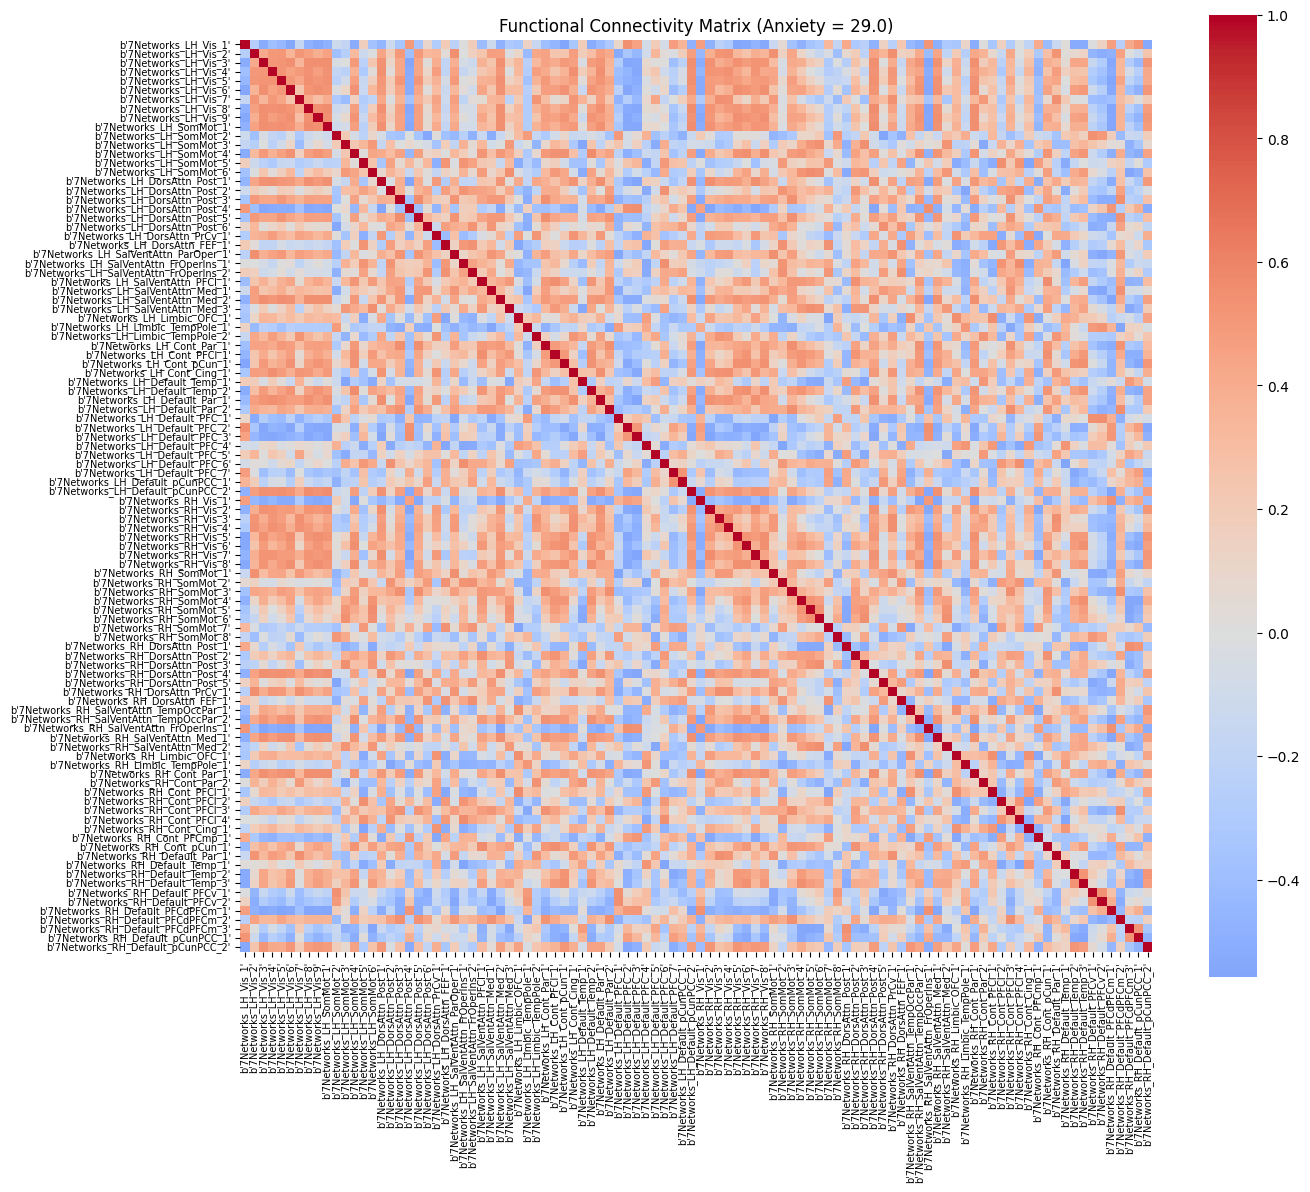

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets

# Load atlas dictionary to get labels
atlas_data = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
labels = atlas_data['labels']

plt.figure(figsize=(14, 12))
sns.heatmap(fc_matrix, xticklabels=labels, yticklabels=labels, cmap="coolwarm", center=0, square=True)

plt.title(f"Functional Connectivity Matrix (Anxiety = {anxiety})")
plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()
plt.show()

Lets make two side by side for lower vs higher anxiety score and see how they compare as sort of a proof of concept

[get_dataset_dir] Dataset found in /Users/emmasombers/nilearn_data/schaefer_2018


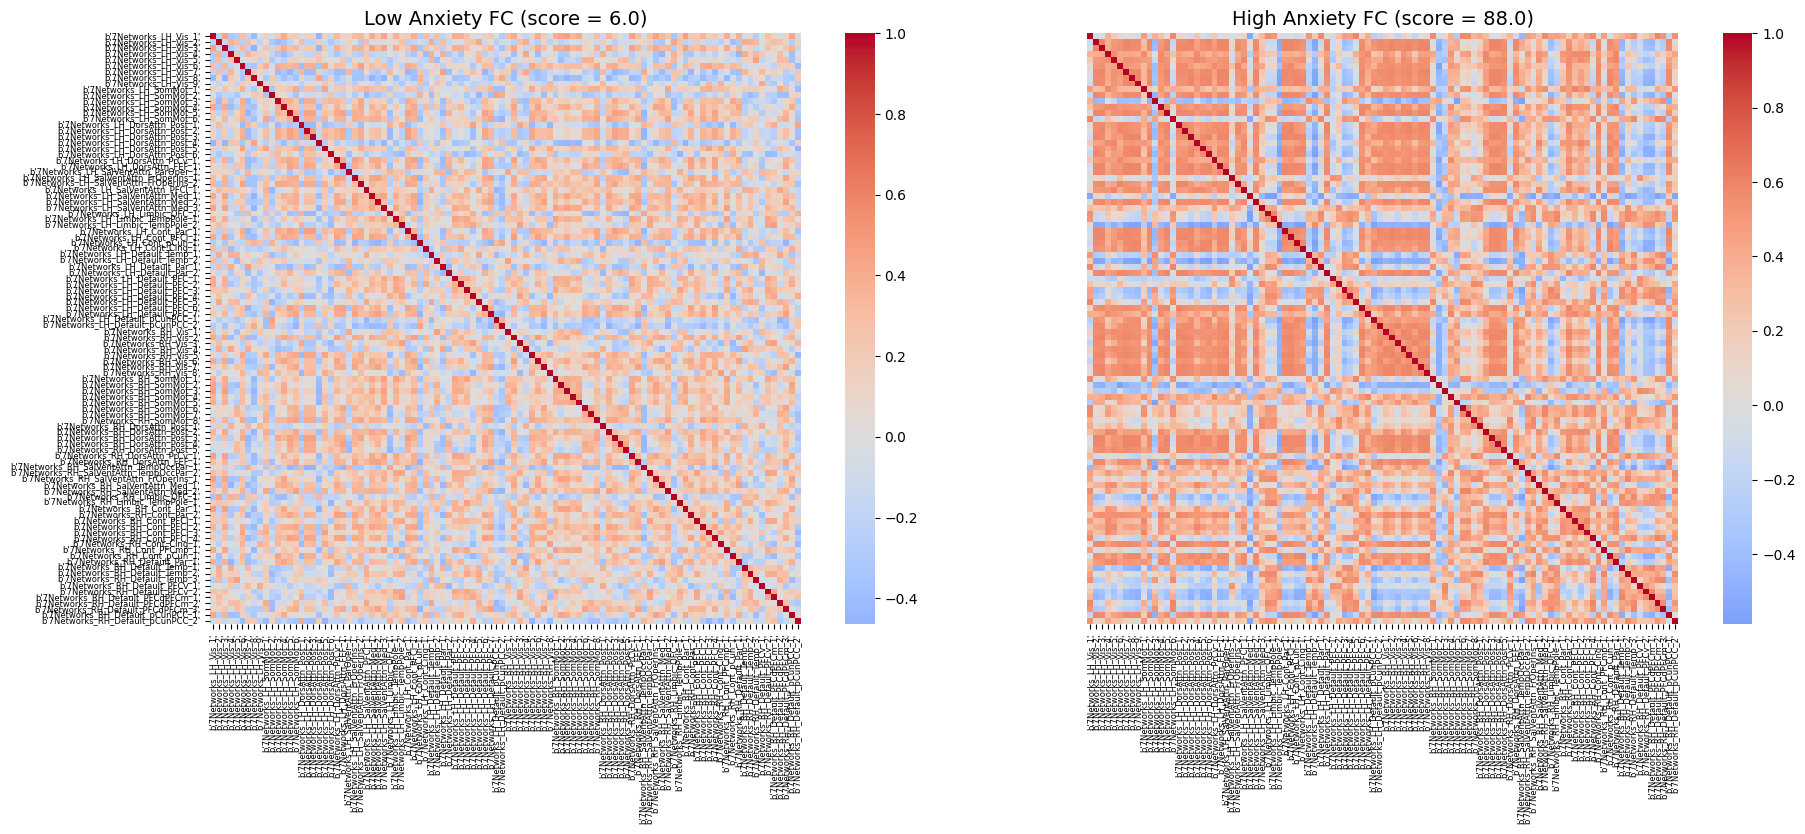

In [160]:
sorted_chunks = sorted(extracted_chunks, key=lambda x: x["anxiety"])

low_anx = sorted_chunks[0]
high_anx = sorted_chunks[-1]

def compute_fc(chunk_4d, tr, affine, masker):
    chunk_img = nib.Nifti1Image(chunk_4d, affine)
    roi_ts = masker.fit_transform(chunk_img)
    fc_matrix = ConnectivityMeasure(kind="correlation").fit_transform([roi_ts])[0]
    return fc_matrix

# Make the masker once
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
labels = atlas["labels"]
masker = NiftiLabelsMasker(labels_img=atlas["maps"], standardize=True, t_r=tr)

# Compute FC matrices
fc_low = compute_fc(low_anx["chunk"], tr, img.affine, masker)
fc_high = compute_fc(high_anx["chunk"], tr, img.affine, masker)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(fc_low, xticklabels=labels, yticklabels=labels, ax=axes[0], center=0, cmap="coolwarm", square=True)
axes[0].set_title(f"Low Anxiety FC (score = {low_anx['anxiety']:.1f})", fontsize=14)
axes[0].tick_params(axis='x', rotation=90, labelsize=6)
axes[0].tick_params(axis='y', labelsize=6)

sns.heatmap(fc_high, xticklabels=labels, yticklabels=False, ax=axes[1], center=0, cmap="coolwarm", square=True)
axes[1].set_title(f"High Anxiety FC (score = {high_anx['anxiety']:.1f})", fontsize=14)
axes[1].tick_params(axis='x', rotation=90, labelsize=6)

plt.tight_layout()
plt.show()

We can also try plotting the difference between matrices to see what happens 

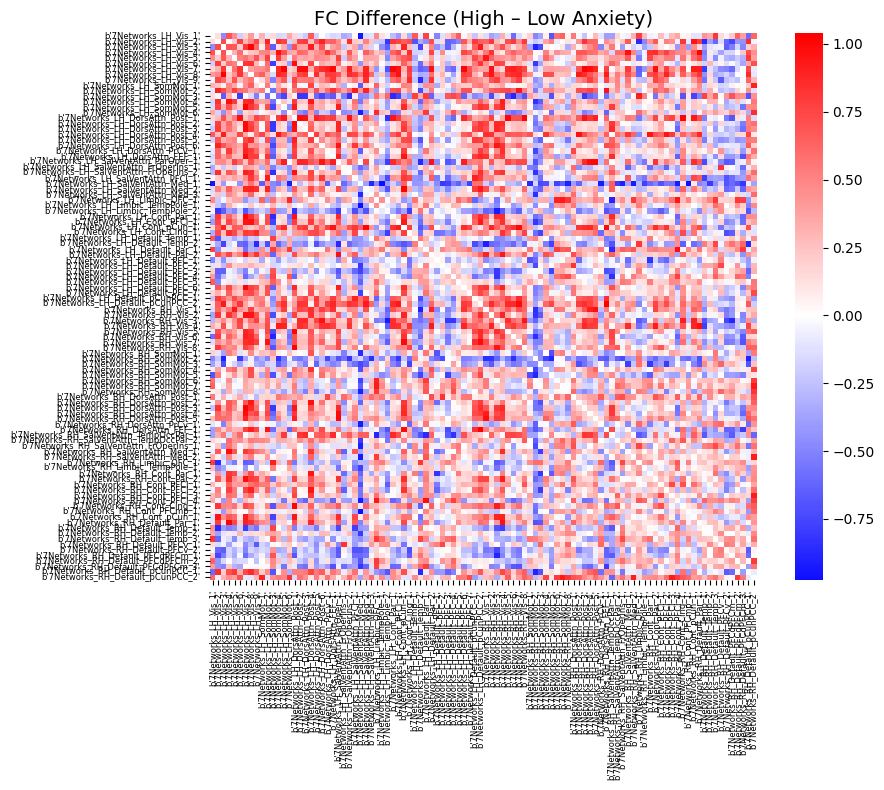

In [161]:
diff_matrix = fc_high - fc_low

plt.figure(figsize=(10, 8))
sns.heatmap(diff_matrix, xticklabels=labels, yticklabels=labels, center=0, cmap="bwr", square=True)

plt.title("FC Difference (High – Low Anxiety)", fontsize=14)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()

- group the networks in a more zoomed out way (put together the vis somat etc.)
- add a simple permutation test 
(randomly shuffle everything and then recalculate) the point is to see if the results are significant 
- need to look at the FC more and see if its making sense on a brain region level 

Also for fun lets see which areas have the strongest difference in FC between high and low anxiety levels 

In [130]:
import numpy as np

diff_matrix = fc_high - fc_low

# mask upper triangle (have to do this to ignore duplicates and self-connections)
n_rois = diff_matrix.shape[0]
mask = np.triu(np.ones((n_rois, n_rois), dtype=bool), k=1)

# extract values + indices
diff_values = diff_matrix[mask]
roi_pairs = np.array(np.where(mask)).T  # shape (num_pairs, 2)

# get top-k by absolute difference
k = 10
top_k_idx = np.argsort(np.abs(diff_values))[::-1][:k]

print(f"Top {k} strongest FC changes between high vs low anxiety:\n")
for i in top_k_idx:
    roi1, roi2 = roi_pairs[i]
    value = diff_values[i]
    print(f"{labels[roi1]} ↔ {labels[roi2]}  |  Change in FC = {value:.3f}")

Top 10 strongest FC changes between high vs low anxiety:

b'7Networks_LH_DorsAttn_PrCv_1' ↔ b'7Networks_RH_Default_Par_1'  |  Change in FC = 1.246
b'7Networks_RH_SomMot_2' ↔ b'7Networks_RH_Limbic_TempPole_1'  |  Change in FC = 1.230
b'7Networks_LH_DorsAttn_Post_1' ↔ b'7Networks_RH_Limbic_OFC_1'  |  Change in FC = 1.227
b'7Networks_LH_SalVentAttn_ParOper_1' ↔ b'7Networks_RH_Default_Par_1'  |  Change in FC = 1.223
b'7Networks_LH_Default_PFC_3' ↔ b'7Networks_RH_Default_Par_1'  |  Change in FC = -1.211
b'7Networks_LH_Limbic_TempPole_1' ↔ b'7Networks_LH_Default_PFC_7'  |  Change in FC = 1.211
b'7Networks_LH_SomMot_4' ↔ b'7Networks_LH_SalVentAttn_PFCl_1'  |  Change in FC = -1.211
b'7Networks_LH_SomMot_4' ↔ b'7Networks_LH_Cont_pCun_1'  |  Change in FC = -1.210
b'7Networks_LH_Vis_9' ↔ b'7Networks_RH_Cont_PFCl_4'  |  Change in FC = -1.207
b'7Networks_LH_SalVentAttn_PFCl_1' ↔ b'7Networks_RH_Cont_Par_2'  |  Change in FC = -1.203


There is a lot of interesting visualization we can do through Nilearn to understand how anxiety affects the brain that we can look into for our report maybe but for now lets move back to tPHATE

Now we will prepare for the low dimensional embedding of our FC! To do this we have to go back and perform the ROI and FC calculations for all of our chunks instead of one like we did before. Then we flatten and stack our FC matrices into a 1D vector so it is in the shape of (n_windows, n_fc_features)

In [131]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
import numpy as np
import nibabel as nib

extracted_chunks_sorted = sorted(extracted_chunks, key=lambda x: x['start_vol'])

# load our brain atlas and initialize masker
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)

## TODO can play around w ROIs, look at it from network level  

atlas_img = atlas["maps"]
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True, t_r=tr)
connectivity = ConnectivityMeasure(kind="correlation")

# Storage
fc_flattened = []
anx_labels = []

for i, chunk_info in enumerate(extracted_chunks):
    try:
        chunk = chunk_info["chunk"]
        anxiety = chunk_info["anxiety"]
        affine = chunk_info["affine"]

        # wrap in Nifti image
        chunk_img = nib.Nifti1Image(chunk, affine=affine)

        # Extract ROI time series
        roi_ts = masker.fit_transform(chunk_img)

        # Compute FC matrix
        fc_matrix = connectivity.fit_transform([roi_ts])[0]

        # Extract upper triangle (excluding diagonal)
        triu_idx = np.triu_indices_from(fc_matrix, k=1)
        fc_vector = fc_matrix[triu_idx]

        fc_flattened.append(fc_vector)
        anx_labels.append(anxiety)

    except Exception as e:
        print(f"⚠️ Error on window {i}: {e}")

# Convert to final array: shape = (n_windows, n_fc_features)
# --- Explanation of FC vector shape ---
# We used the Schaefer 100 ROI atlas to extract functional connectivity (FC) matrices.
# Each FC matrix is 100 x 100 (ROIs × ROIs).
# Since the FC matrix is symmetric, we only use the upper triangle (excluding the diagonal).
# That gives us 100 * (100 - 1) / 2 = 4950 unique connections per window.
# These 4950 values form the feature vector for each fMRI chunk.
# So our final dataset shape is: (n_windows, 4950)
fc_data = np.array(fc_flattened)
anx_labels = np.array(anx_labels)

print("FC matrix shape for embedding:", fc_data.shape)
print("Anxiety labels shape:", anx_labels.shape)

[get_dataset_dir] Dataset found in /Users/emmasombers/nilearn_data/schaefer_2018
FC matrix shape for embedding: (18, 4950)
Anxiety labels shape: (18,)


# tPHATE

The point of tPHATE:
	•	Learns a low-dimensional trajectory from temporally ordered high-dim data
	•	Preserves both global structure and local transitions
	•	Outputs a smooth embedding that tracks how brain states evolve over time

In [90]:
%pip install tphate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Calculating TPHATE...
  Running TPHATE on 20 observations and 4950 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Learning the autocorrelation function...
  Calculating Autocorr kernel...
    Dropoff point: 1
  Combining PHATE operator and autocorr operator
  No autocorrelation measured; converging with PHATE
  Calculating optimal t...
    Automatically selected t = 5
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated TPHATE in 0.09 seconds.


/Users/emmasombers/Library/Python/3.9/lib/python/site-packages/tphate/graphs.py:124: UserWarning: Building a kNNGraph on data of shape (20, 4950) is expensive. Consider setting n_pca.
  warnings.warn(


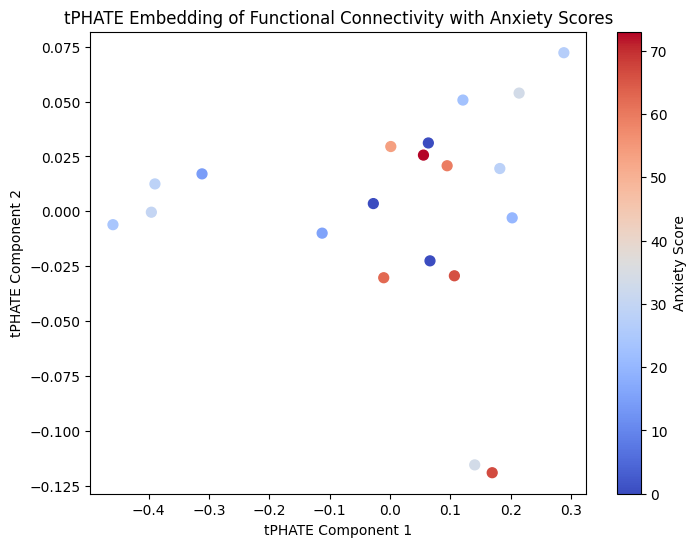

In [94]:
import tphate 

tphate_op = tphate.TPHATE(n_components=2, knn=5, decay=20)
fc_embedding = tphate_op.fit_transform(fc_data)

# Visualize the tPHATE result and incorporate the anxiety scores as a color bar
plt.figure(figsize=(8, 6))
sc = plt.scatter(fc_embedding[:, 0], fc_embedding[:, 1], c=anx_labels, cmap='coolwarm', s=50)
plt.title("tPHATE Embedding of Functional Connectivity with Anxiety Scores")
plt.xlabel("tPHATE Component 1")
plt.ylabel("tPHATE Component 2")
plt.colorbar(sc, label="Anxiety Score")
plt.show()

- try playing around w the tPHATE dimensionality (3?)
- try clustering 
- run a mixed effects model w more subject data and have each tPHATE component as its own independent variable and the subject try to predict 
- what we are saying is these components are reflective of a diff brain state 
- how does it look when multiple subjects are in one latent space 

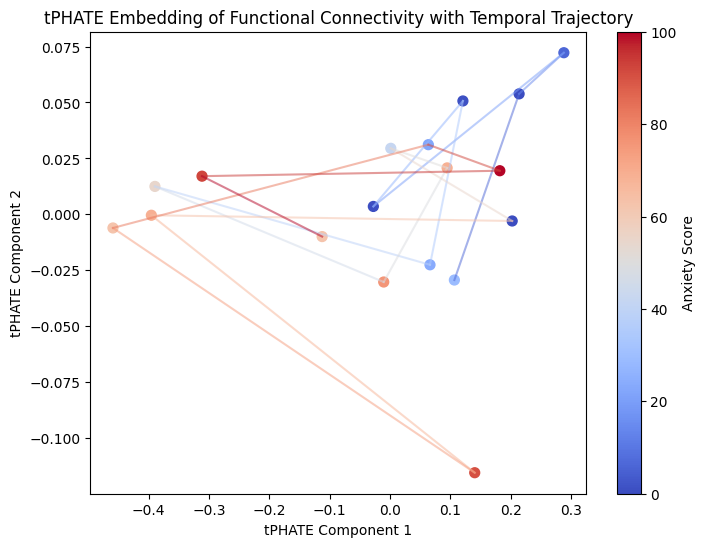

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by start_vol to maintain temporal order
start_vols = [chunk_info["start_vol"] for chunk_info in extracted_chunks]
sorted_indices = np.argsort(start_vols)  # Sort based on start_vol

# Sorting the data by start_vol
sorted_embedding = fc_embedding[sorted_indices, :]
sorted_start_vols = np.array(start_vols)[sorted_indices]
sorted_anxiety = np.array(anx_labels)[sorted_indices]

# Plotting the temporal trajectory
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    sorted_embedding[:, 0], sorted_embedding[:, 1],
    c=sorted_anxiety, cmap='coolwarm', s=50
)
# Connect the points based on temporal order (by start_vol)
for i in range(1, len(sorted_embedding)):
    plt.plot(
        [sorted_embedding[i-1, 0], sorted_embedding[i, 0]], 
        [sorted_embedding[i-1, 1], sorted_embedding[i, 1]], 
        color=plt.cm.coolwarm((sorted_start_vols[i] - sorted_start_vols[0]) / (sorted_start_vols[-1] - sorted_start_vols[0])),
        alpha=0.5  # Make lines semi-transparent
    )

plt.title('tPHATE Embedding of Functional Connectivity with Temporal Trajectory')
plt.xlabel('tPHATE Component 1')
plt.ylabel('tPHATE Component 2')

# Add a color bar to represent anxiety scores
cbar = plt.colorbar(scatter)
cbar.set_label('Anxiety Score')

# Show the plot
plt.show()

This plot shows the tPHATE embedding of functional connectivity (FC) matrices, with each point representing a chunk of fMRI data that corresponds to a reported anxiety level while watching the film. The points are color-coded by anxiety score, with higher anxiety levels indicated in red and lower anxiety levels in blue. The lines connecting the points represent the temporal trajectory of each chunk, with the x- and y-axes corresponding to the first and second components of the tPHATE embedding. This visualization highlights how FC patterns evolve over time, where you can see that different anxiety levels exist at different points in the latent space. 

[get_dataset_dir] Dataset found in /Users/emmasombers/nilearn_data/fsl


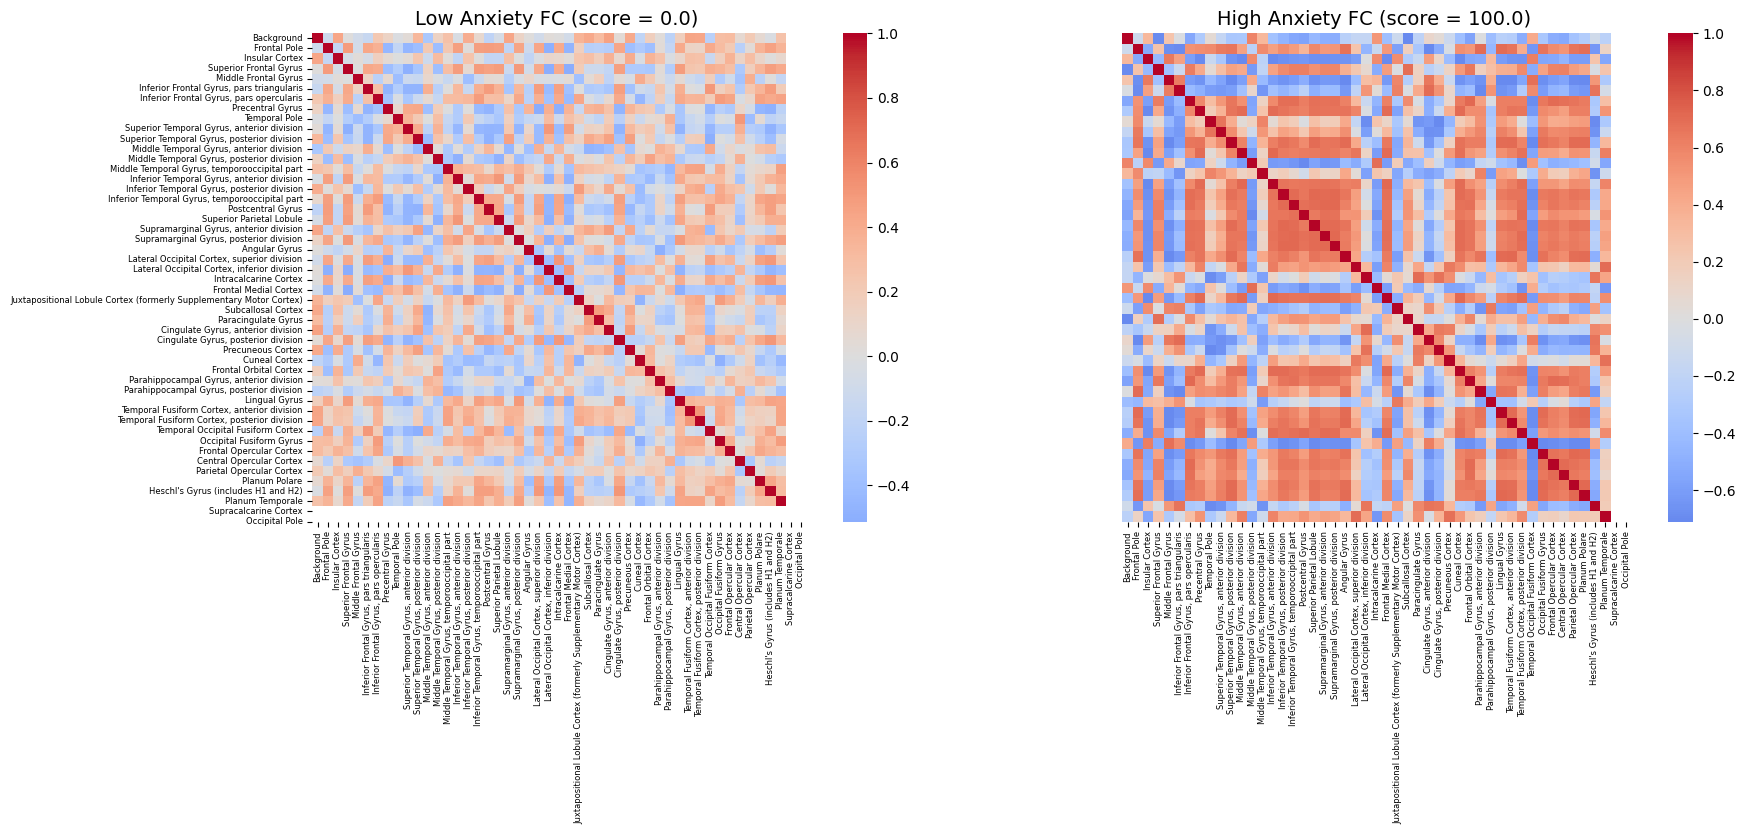

In [133]:
#try diff atlas

from nilearn import datasets

sorted_chunks = sorted(extracted_chunks, key=lambda x: x["anxiety"])

low_anx = sorted_chunks[0]
high_anx = sorted_chunks[-1]

def compute_fc(chunk_4d, tr, affine, masker):
    chunk_img = nib.Nifti1Image(chunk_4d, affine)
    roi_ts = masker.fit_transform(chunk_img)
    fc_matrix = ConnectivityMeasure(kind="correlation").fit_transform([roi_ts])[0]
    return fc_matrix

# Make the masker once
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-1mm')
labels = atlas["labels"]
masker = NiftiLabelsMasker(labels_img=atlas["maps"], standardize=True, t_r=tr)

# Compute FC matrices
fc_low = compute_fc(low_anx["chunk"], tr, img.affine, masker)
fc_high = compute_fc(high_anx["chunk"], tr, img.affine, masker)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(fc_low, xticklabels=labels, yticklabels=labels, ax=axes[0], center=0, cmap="coolwarm", square=True)
axes[0].set_title(f"Low Anxiety FC (score = {low_anx['anxiety']:.1f})", fontsize=14)
axes[0].tick_params(axis='x', rotation=90, labelsize=6)
axes[0].tick_params(axis='y', labelsize=6)

sns.heatmap(fc_high, xticklabels=labels, yticklabels=False, ax=axes[1], center=0, cmap="coolwarm", square=True)
axes[1].set_title(f"High Anxiety FC (score = {high_anx['anxiety']:.1f})", fontsize=14)
axes[1].tick_params(axis='x', rotation=90, labelsize=6)

plt.tight_layout()
plt.show()

In [162]:
print(atlas['labels'])
print(atlas)

[b'7Networks_LH_Vis_1' b'7Networks_LH_Vis_2' b'7Networks_LH_Vis_3'
 b'7Networks_LH_Vis_4' b'7Networks_LH_Vis_5' b'7Networks_LH_Vis_6'
 b'7Networks_LH_Vis_7' b'7Networks_LH_Vis_8' b'7Networks_LH_Vis_9'
 b'7Networks_LH_SomMot_1' b'7Networks_LH_SomMot_2'
 b'7Networks_LH_SomMot_3' b'7Networks_LH_SomMot_4'
 b'7Networks_LH_SomMot_5' b'7Networks_LH_SomMot_6'
 b'7Networks_LH_DorsAttn_Post_1' b'7Networks_LH_DorsAttn_Post_2'
 b'7Networks_LH_DorsAttn_Post_3' b'7Networks_LH_DorsAttn_Post_4'
 b'7Networks_LH_DorsAttn_Post_5' b'7Networks_LH_DorsAttn_Post_6'
 b'7Networks_LH_DorsAttn_PrCv_1' b'7Networks_LH_DorsAttn_FEF_1'
 b'7Networks_LH_SalVentAttn_ParOper_1'
 b'7Networks_LH_SalVentAttn_FrOperIns_1'
 b'7Networks_LH_SalVentAttn_FrOperIns_2'
 b'7Networks_LH_SalVentAttn_PFCl_1' b'7Networks_LH_SalVentAttn_Med_1'
 b'7Networks_LH_SalVentAttn_Med_2' b'7Networks_LH_SalVentAttn_Med_3'
 b'7Networks_LH_Limbic_OFC_1' b'7Networks_LH_Limbic_TempPole_1'
 b'7Networks_LH_Limbic_TempPole_2' b'7Networks_LH_Cont_Par_1'
 

In [164]:
# group the ROIs into their networks 

network_map = {
    "Visual": [b'7Networks_LH_Vis_1', b'7Networks_LH_Vis_2', b'7Networks_LH_Vis_3', b'7Networks_LH_Vis_4', 
               b'7Networks_LH_Vis_5', b'7Networks_LH_Vis_6', b'7Networks_LH_Vis_7', b'7Networks_LH_Vis_8',
               b'7Networks_LH_Vis_9', b'7Networks_RH_Vis_1', b'7Networks_RH_Vis_2', b'7Networks_RH_Vis_3',
               b'7Networks_RH_Vis_4', b'7Networks_RH_Vis_5', b'7Networks_RH_Vis_6', b'7Networks_RH_Vis_7',
               b'7Networks_RH_Vis_8'],
    "Somatomotor": [b'7Networks_LH_SomMot_1', b'7Networks_LH_SomMot_2', b'7Networks_LH_SomMot_3', 
                    b'7Networks_LH_SomMot_4', b'7Networks_LH_SomMot_5', b'7Networks_LH_SomMot_6', 
                    b'7Networks_RH_SomMot_1', b'7Networks_RH_SomMot_2', b'7Networks_RH_SomMot_3',
                    b'7Networks_RH_SomMot_4', b'7Networks_RH_SomMot_5', b'7Networks_RH_SomMot_6'],
    "Dorsal Attention": [b'7Networks_LH_DorsAttn_Post_1', b'7Networks_LH_DorsAttn_Post_2', 
                         b'7Networks_LH_DorsAttn_Post_3', b'7Networks_LH_DorsAttn_Post_4', 
                         b'7Networks_LH_DorsAttn_Post_5', b'7Networks_LH_DorsAttn_Post_6',
                         b'7Networks_LH_DorsAttn_PrCv_1', b'7Networks_RH_DorsAttn_Post_1', 
                         b'7Networks_RH_DorsAttn_Post_2', b'7Networks_RH_DorsAttn_Post_3',
                         b'7Networks_RH_DorsAttn_Post_4', b'7Networks_RH_DorsAttn_Post_5',
                         b'7Networks_RH_DorsAttn_PrCv_1'],
    "Salience and Ventral Attention": [b'7Networks_LH_SalVentAttn_ParOper_1', 
                                       b'7Networks_LH_SalVentAttn_FrOperIns_1', 
                                       b'7Networks_RH_SalVentAttn_TempOccPar_1', 
                                       b'7Networks_RH_SalVentAttn_TempOccPar_2', 
                                       b'7Networks_RH_SalVentAttn_FrOperIns_1'],
    "Limbic": [b'7Networks_LH_Limbic_OFC_1', b'7Networks_LH_Limbic_TempPole_1', 
               b'7Networks_LH_Limbic_TempPole_2', b'7Networks_RH_Limbic_OFC_1', 
               b'7Networks_RH_Limbic_TempPole_1'],
    "Control": [b'7Networks_LH_Cont_Par_1', b'7Networks_LH_Cont_PFCl_1', 
                b'7Networks_LH_Cont_pCun_1', b'7Networks_LH_Cont_Cing_1', 
                b'7Networks_RH_Cont_Par_1', b'7Networks_RH_Cont_Par_2', 
                b'7Networks_RH_Cont_PFCl_1', b'7Networks_RH_Cont_PFCl_2', 
                b'7Networks_RH_Cont_PFCl_3', b'7Networks_RH_Cont_PFCl_4'],
    "Default Mode": [b'7Networks_LH_Default_Temp_1', b'7Networks_LH_Default_Temp_2', 
                     b'7Networks_LH_Default_Par_1', b'7Networks_LH_Default_Par_2', 
                     b'7Networks_LH_Default_PFC_1', b'7Networks_LH_Default_PFC_2', 
                     b'7Networks_LH_Default_PFC_3', b'7Networks_LH_Default_PFC_4', 
                     b'7Networks_LH_Default_PFC_5', b'7Networks_LH_Default_PFC_6', 
                     b'7Networks_LH_Default_PFC_7', b'7Networks_LH_Default_pCunPCC_1',
                     b'7Networks_LH_Default_pCunPCC_2', b'7Networks_RH_Default_Par_1', 
                     b'7Networks_RH_Default_Temp_1', b'7Networks_RH_Default_Temp_2', 
                     b'7Networks_RH_Default_Temp_3', b'7Networks_RH_Default_PFCv_1', 
                     b'7Networks_RH_Default_PFCv_2', b'7Networks_RH_Default_PFCdPFCm_1',
                     b'7Networks_RH_Default_PFCdPFCm_2', b'7Networks_RH_Default_PFCdPFCm_3', 
                     b'7Networks_RH_Default_pCunPCC_1', b'7Networks_RH_Default_pCunPCC_2']
}

# Map regions to their respective networks
grouped_regions = {network: [] for network in network_map}

for idx, label in enumerate(labels):
    for network, regions in network_map.items():
        if label in regions:
            grouped_regions[network].append(idx)

# Print the grouped regions to verify
for network, regions in grouped_regions.items():
    print(f"{network}: {regions}")

Visual: [0, 1, 2, 3, 4, 5, 6, 7, 8, 50, 51, 52, 53, 54, 55, 56, 57]
Somatomotor: [9, 10, 11, 12, 13, 14, 58, 59, 60, 61, 62, 63]
Dorsal Attention: [15, 16, 17, 18, 19, 20, 21, 66, 67, 68, 69, 70, 71]
Salience and Ventral Attention: [23, 24, 73, 74, 75]
Limbic: [30, 31, 32, 78, 79]
Control: [33, 34, 35, 36, 80, 81, 82, 83, 84, 85]
Default Mode: [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


[get_dataset_dir] Dataset found in /Users/emmasombers/nilearn_data/schaefer_2018


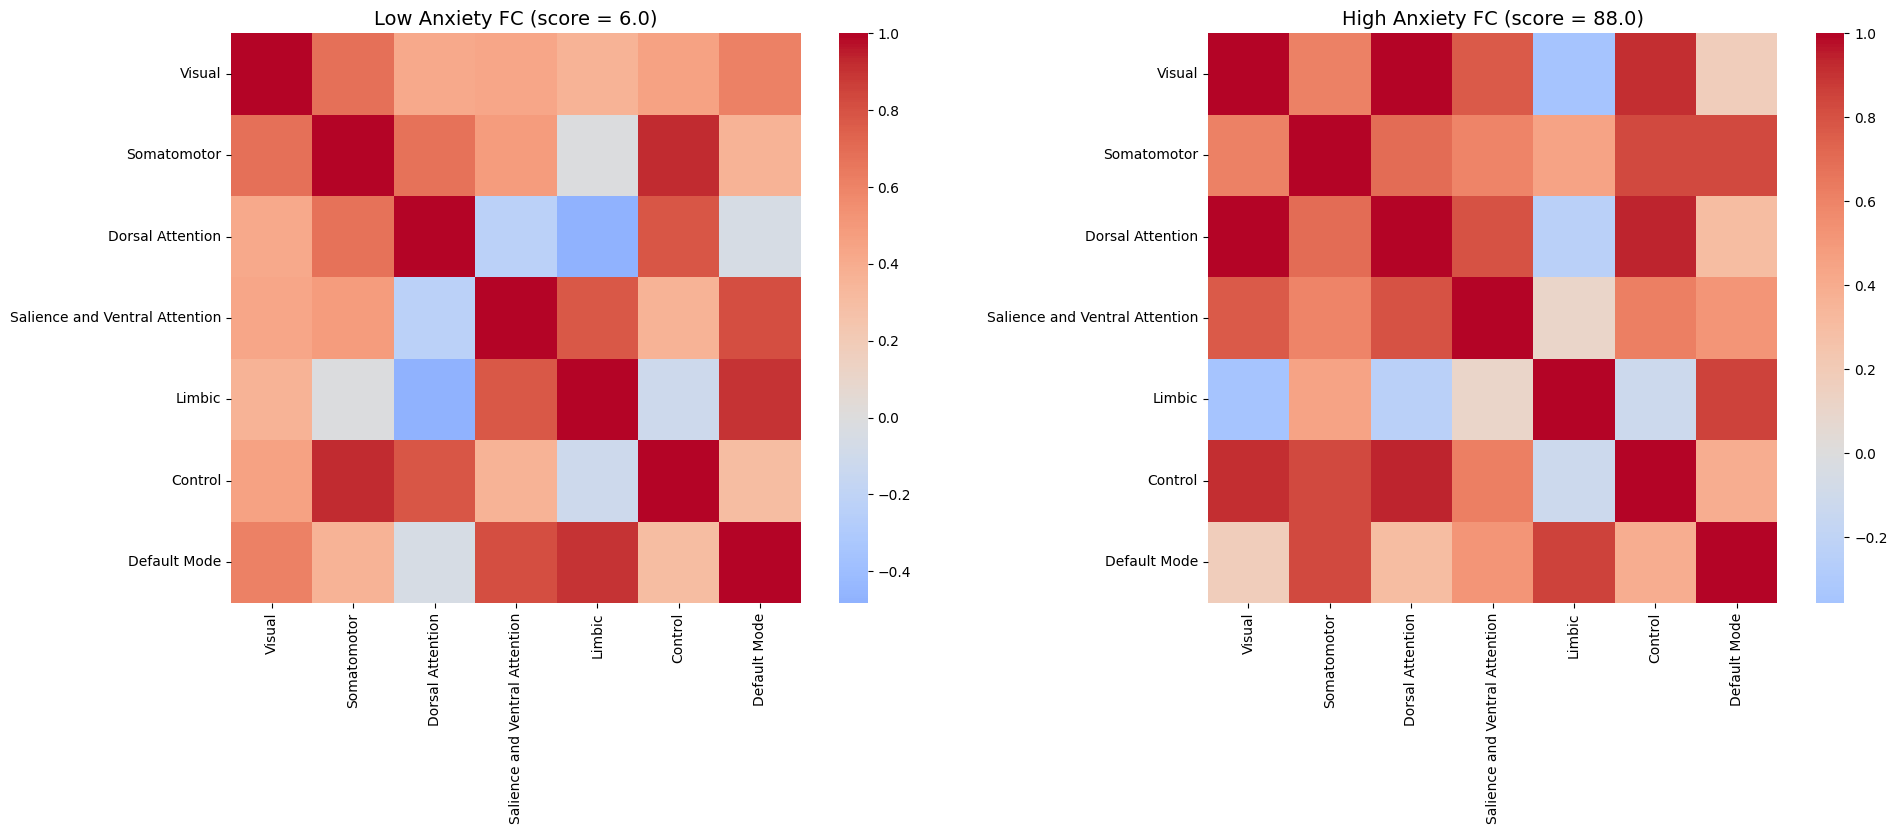

In [ ]:
sorted_chunks = sorted(extracted_chunks, key=lambda x: x["anxiety"])
low_anx = sorted_chunks[0]
high_anx = sorted_chunks[-1]

def compute_fc(chunk_4d, tr, affine, masker):
    chunk_img = nib.Nifti1Image(chunk_4d, affine)
    roi_ts = masker.fit_transform(chunk_img)
    fc_matrix = ConnectivityMeasure(kind="correlation").fit_transform([roi_ts])[0]
    return fc_matrix

# Fetch Schaefer 2018 atlas with 100 ROIs (including networks)
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
labels = atlas["labels"]
masker = NiftiLabelsMasker(labels_img=atlas["maps"], standardize=True, t_r=tr)

# Group regions by network (use index mapping from network_map)
network_groupings = {network: [] for network in network_map}
for idx, label in enumerate(labels):
    for network, regions in network_map.items():
        if label in regions:
            network_groupings[network].append(idx)

# Compute FC by using the network groupings
def compute_grouped_fc(chunk_4d, tr, affine, network_groupings, masker):
    chunk_img = nib.Nifti1Image(chunk_4d, affine)
    roi_ts = masker.fit_transform(chunk_img)
    
    # Create a new FC matrix based on network groupings
    fc_matrix_grouped = np.zeros((len(network_groupings), len(network_groupings)))
    
    for i, (network_1, regions_1) in enumerate(network_groupings.items()):
        for j, (network_2, regions_2) in enumerate(network_groupings.items()):
            # Compute the mean time series for each network
            ts_1 = np.mean(roi_ts[:, regions_1], axis=1) if regions_1 else np.zeros(roi_ts.shape[0])
            ts_2 = np.mean(roi_ts[:, regions_2], axis=1) if regions_2 else np.zeros(roi_ts.shape[0])
            
            # Compute correlation between the two networks' time series
            fc_matrix_grouped[i, j] = np.corrcoef(ts_1, ts_2)[0, 1]
    
    return fc_matrix_grouped

# Compute FC matrices for low and high anxiety
fc_low = compute_grouped_fc(low_anx["chunk"], tr, img.affine, network_groupings, masker)
fc_high = compute_grouped_fc(high_anx["chunk"], tr, img.affine, network_groupings, masker)

# Plot the FC matrices with grouped networks
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(fc_low, xticklabels=network_groupings.keys(), yticklabels=network_groupings.keys(), ax=axes[0], center=0, cmap="coolwarm", square=True)
axes[0].set_title(f"Low Anxiety FC (score = {low_anx['anxiety']:.1f})", fontsize=14)

sns.heatmap(fc_high, xticklabels=network_groupings.keys(), yticklabels=network_groupings.keys(), ax=axes[1], center=0, cmap="coolwarm", square=True)
axes[1].set_title(f"High Anxiety FC (score = {high_anx['anxiety']:.1f})", fontsize=14)

plt.tight_layout()
plt.show()

Functional Connectivity Difference: High Anxiety - Low Anxiety:
Visual ↔ Visual | FC Difference: 0.000
Visual ↔ Somatomotor | FC Difference: -0.071
Visual ↔ Dorsal Attention | FC Difference: 0.573
Visual ↔ Salience and Ventral Attention | FC Difference: 0.335
Visual ↔ Limbic | FC Difference: -0.713
Visual ↔ Control | FC Difference: 0.462
Visual ↔ Default Mode | FC Difference: -0.439
Somatomotor ↔ Visual | FC Difference: -0.071
Somatomotor ↔ Somatomotor | FC Difference: 0.000
Somatomotor ↔ Dorsal Attention | FC Difference: 0.030
Somatomotor ↔ Salience and Ventral Attention | FC Difference: 0.106
Somatomotor ↔ Limbic | FC Difference: 0.462
Somatomotor ↔ Control | FC Difference: -0.088
Somatomotor ↔ Default Mode | FC Difference: 0.467
Dorsal Attention ↔ Visual | FC Difference: 0.573
Dorsal Attention ↔ Somatomotor | FC Difference: 0.030
Dorsal Attention ↔ Dorsal Attention | FC Difference: -0.000
Dorsal Attention ↔ Salience and Ventral Attention | FC Difference: 1.037
Dorsal Attention ↔ Lim

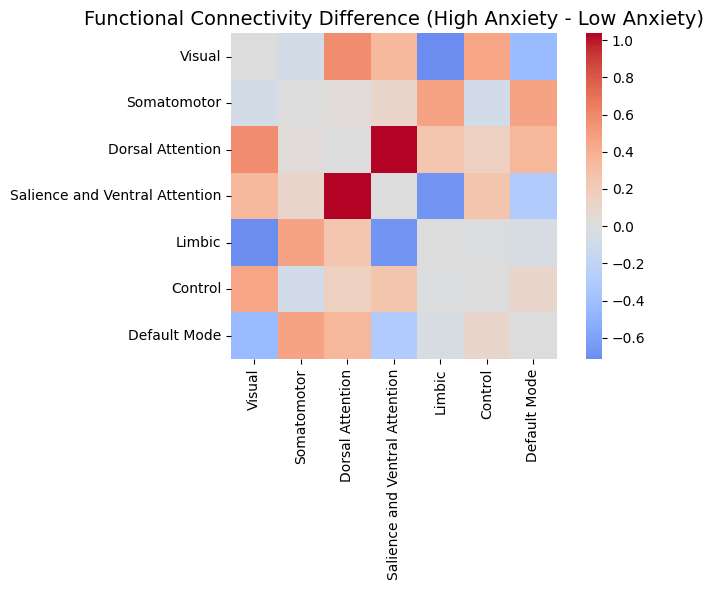

In [166]:
# Calculate the difference between high and low anxiety FC matrices
fc_diff = fc_high - fc_low

# Print the FC difference between the two conditions
print("Functional Connectivity Difference: High Anxiety - Low Anxiety:")
for i, network_1 in enumerate(network_groupings):
    for j, network_2 in enumerate(network_groupings):
        print(f"{network_1} ↔ {network_2} | FC Difference: {fc_diff[i, j]:.3f}")

# Plot the FC difference matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(fc_diff, xticklabels=network_groupings, yticklabels=network_groupings, ax=ax, center=0, cmap="coolwarm", square=True)
ax.set_title("Functional Connectivity Difference (High Anxiety - Low Anxiety)", fontsize=14)
plt.tight_layout()
plt.show()

note: positive means it is more connected in high anxiety, and negative means it is more connected in low anxiety. From here we are seeing that in high anixety salience and ventral attention is much more connected with dorsal attention, and control with dorsal attention is also notable. in lower anxiety limbic and somatomotor are more connected (therefore less connected in high anxiety) as well as somatomotor and DMN 

# Grouping together anxiety from 0-33 and 66-100

In [175]:
low_anx_chunks = []
high_anx_chunks = []

for chunk in extracted_chunks:
    anxiety = chunk["anxiety"]
    if anxiety <= 33:
        low_anx_chunks.append(chunk)
    elif anxiety >= 66:
        high_anx_chunks.append(chunk)

print(len(low_anx_chunks))
print(len(high_anx_chunks))

7
10


In [174]:
fc_low = np.mean([compute_grouped_fc(chunk["chunk"], tr, img.affine, network_groupings, masker) 
                  for chunk in low_anx_chunks], axis=0) if low_anx_chunks else None

fc_high = np.mean([compute_grouped_fc(chunk["chunk"], tr, img.affine, network_groupings, masker) 
                   for chunk in high_anx_chunks], axis=0) if high_anx_chunks else None

# 3. Calculate the FC difference between high and low anxiety groups
fc_diff = fc_high - fc_low if fc_low is not None and fc_high is not None else None

# Output the results
if fc_diff is not None:
    print(f"FC difference between High and Low Anxiety groups calculated.")
    print(f"Low Anxiety FC: {fc_low}")
    print(f"High Anxiety FC: {fc_high}")
    print(f"FC Difference: {fc_diff}")
else:
    print("Unable to calculate FC difference due to missing data.")

FC difference between High and Low Anxiety groups calculated.
Low Anxiety FC: [[1.         0.51053096 0.79144226 0.29775804 0.22370081 0.61965422
  0.34695355]
 [0.51053096 1.         0.48571652 0.67479513 0.33782883 0.55818425
  0.4262255 ]
 [0.79144226 0.48571652 1.         0.22284787 0.17912039 0.83828517
  0.38612629]
 [0.29775804 0.67479513 0.22284787 1.         0.61078961 0.34796985
  0.59551712]
 [0.22370081 0.33782883 0.17912039 0.61078961 1.         0.27026139
  0.56901336]
 [0.61965422 0.55818425 0.83828517 0.34796985 0.27026139 1.
  0.69005414]
 [0.34695355 0.4262255  0.38612629 0.59551712 0.56901336 0.69005414
  1.        ]]
High Anxiety FC: [[1.         0.41021911 0.58895855 0.28931813 0.40040038 0.34431168
  0.42847759]
 [0.41021911 1.         0.66679433 0.85026107 0.40477572 0.69191345
  0.67277226]
 [0.58895855 0.66679433 1.         0.63447776 0.37066701 0.79895681
  0.69805309]
 [0.28931813 0.85026107 0.63447776 1.         0.37067662 0.70095822
  0.6033496 ]
 [0.400400

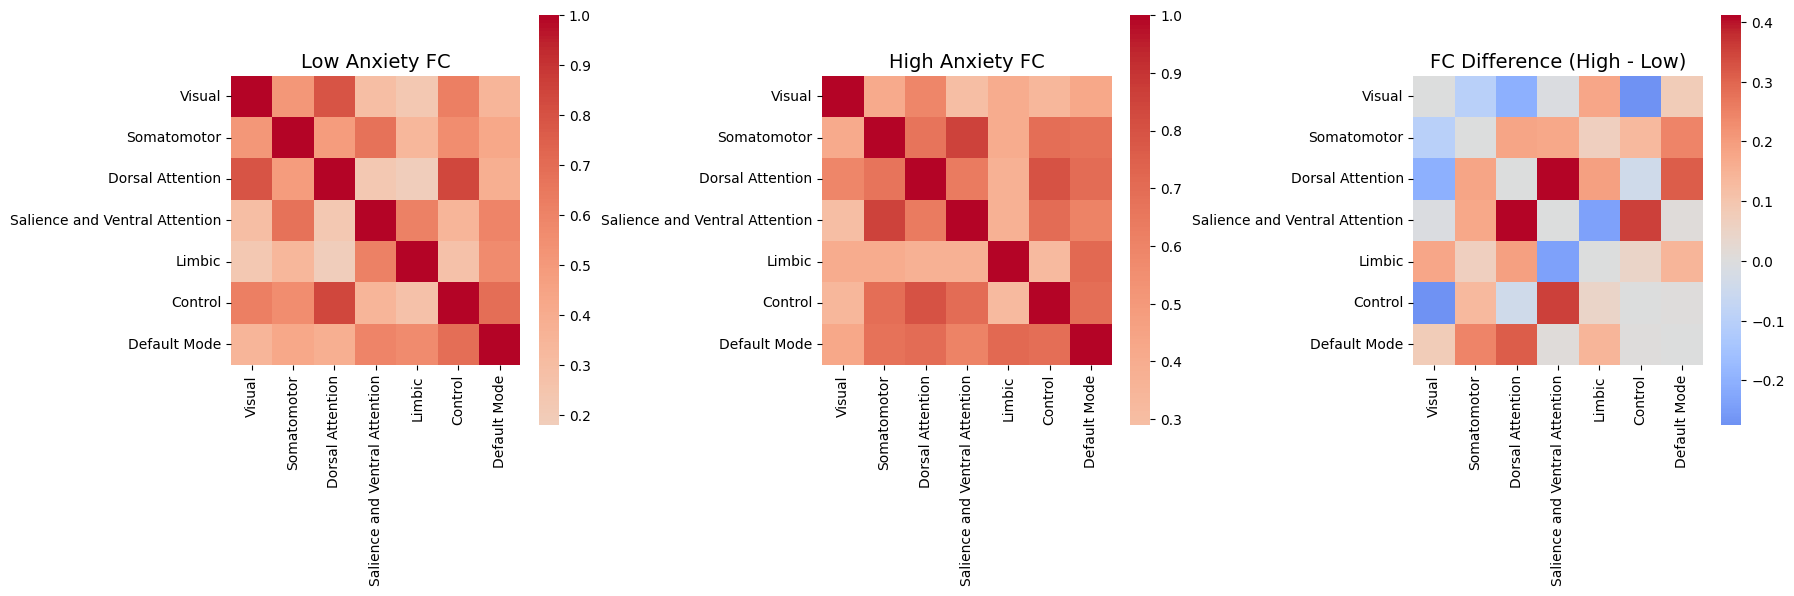

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the FC matrices for low and high anxiety, and their difference
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Low Anxiety FC
sns.heatmap(fc_low, xticklabels=network_groupings.keys(), yticklabels=network_groupings.keys(), 
            ax=axes[0], center=0, cmap="coolwarm", square=True)
axes[0].set_title("Low Anxiety FC", fontsize=14)

# Plot High Anxiety FC
sns.heatmap(fc_high, xticklabels=network_groupings.keys(), yticklabels=network_groupings.keys(), 
            ax=axes[1], center=0, cmap="coolwarm", square=True)
axes[1].set_title("High Anxiety FC", fontsize=14)

# Plot FC Difference (High - Low)
sns.heatmap(fc_diff, xticklabels=network_groupings.keys(), yticklabels=network_groupings.keys(), 
            ax=axes[2], center=0, cmap="coolwarm", square=True)
axes[2].set_title("FC Difference (High - Low)", fontsize=14)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

# Permutation Test

In [149]:
import numpy as np
from sklearn.utils import shuffle

# Step 1: Compute the observed FC difference
fc_low = np.mean([compute_grouped_fc(chunk["chunk"], tr, img.affine, network_groupings, masker) for chunk in low_anx_chunks], axis=0) if low_anx_chunks else None
fc_high = np.mean([compute_grouped_fc(chunk["chunk"], tr, img.affine, network_groupings, masker) for chunk in high_anx_chunks], axis=0) if high_anx_chunks else None

# Calculate the observed difference (this is what we want to test)
observed_diff = fc_high - fc_low
observed_diff_flat = observed_diff.flatten()

# Step 2: Permutation testing
n_permutations = 100  # Set the number of permutations
permuted_diffs = []

# Combine low and high anxiety chunks together and shuffle the labels
all_anxiety_chunks = low_anx_chunks + high_anx_chunks

for _ in range(n_permutations):
    # Shuffle the labels
    shuffled_chunks = shuffle(all_anxiety_chunks)
    
    # Split the shuffled chunks into low and high anxiety again (split at the original sizes)
    permuted_low = shuffled_chunks[:len(low_anx_chunks)]
    permuted_high = shuffled_chunks[len(low_anx_chunks):]
    
    # Compute FC for permuted low and high anxiety groups
    fc_low_permuted = np.mean([compute_grouped_fc(chunk["chunk"], tr, img.affine, network_groupings, masker) for chunk in permuted_low], axis=0) if permuted_low else None
    fc_high_permuted = np.mean([compute_grouped_fc(chunk["chunk"], tr, img.affine, network_groupings, masker) for chunk in permuted_high], axis=0) if permuted_high else None
    
    # Calculate the difference for this permutation and flatten it
    permuted_diff = fc_high_permuted - fc_low_permuted
    permuted_diffs.append(permuted_diff.flatten())

# Step 3: Calculate p-value
permuted_diffs = np.array(permuted_diffs)
p_values = np.mean(permuted_diffs >= observed_diff_flat, axis=0)

# Step 4: Output results
print("Observed Difference (flattened):", observed_diff_flat)
print("Permutation p-values:", p_values)

Observed Difference (flattened): [ 0.00000000e+00 -1.00311852e-01 -2.02483707e-01 -8.43990482e-03
  1.76699571e-01 -2.75342535e-01  8.15240408e-02 -1.00311852e-01
  0.00000000e+00  1.81077807e-01  1.75465943e-01  6.69468964e-02
  1.33729197e-01  2.46546761e-01 -2.02483707e-01  1.81077807e-01
 -2.22044605e-16  4.11629895e-01  1.91546615e-01 -3.93283587e-02
  3.11926803e-01 -8.43990482e-03  1.75465943e-01  4.11629895e-01
  0.00000000e+00 -2.40112992e-01  3.52988366e-01  7.83247597e-03
  1.76699571e-01  6.69468964e-02  1.91546615e-01 -2.40112992e-01
  0.00000000e+00  4.46507073e-02  1.42811187e-01 -2.75342535e-01
  1.33729197e-01 -3.93283587e-02  3.52988366e-01  4.46507073e-02
  0.00000000e+00  4.31386954e-03  8.15240408e-02  2.46546761e-01
  3.11926803e-01  7.83247597e-03  1.42811187e-01  4.31386954e-03
 -2.22044605e-16]
Permutation p-values: [1.   0.6  0.88 0.45 0.23 0.8  0.31 0.6  1.   0.17 0.06 0.39 0.27 0.06
 0.88 0.17 1.   0.04 0.2  0.61 0.04 0.45 0.06 0.04 1.   0.78 0.05 0.43
 0.23

(49,)


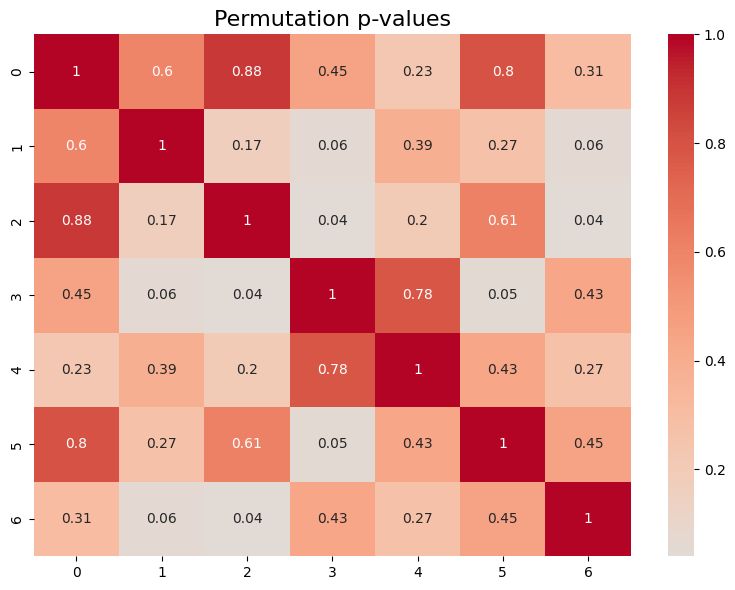

In [153]:
print(p_values.shape)
len(np.unique(p_values))

matrix_size = int(np.sqrt(len(p_values)))  # Assuming it's a square matrix for visualization
permuted_p_values_matrix = p_values[:matrix_size**2].reshape(matrix_size, matrix_size)

# Create a heatmap to visualize permutation p-values
plt.figure(figsize=(8, 6))
sns.heatmap(permuted_p_values_matrix, cmap='coolwarm', annot=True, center=0)
plt.title("Permutation p-values", fontsize=16)
plt.tight_layout()
plt.show()


# try extracting features from low vs high anx chunks

The goal here is to see if we can predict if a chunk is from low anxiety or high anxiety using FC features as a way to train the model. 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = []  # Features (flattened FC)
y = []  # Labels (0 = low anxiety, 1 = high anxiety)

# Process the low anxiety chunks
for chunk in low_anx_chunks:
    fc = compute_fc(chunk["chunk"], tr, affine, masker)
    X.append(fc.flatten())  # Flatten FC to a 1D feature vector
    y.append(0)  # Label for low anxiety

# Process the high anxiety chunks
for chunk in high_anx_chunks:
    fc = compute_fc(chunk["chunk"], tr, affine, masker)
    X.append(fc.flatten())  # Flatten FC to a 1D feature vector
    y.append(1)  # Label for high anxiety

17


In [190]:
print(len(X))
print(y)

17
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [193]:
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Size of training data: {X_train.shape[0]} samples")
print(f"Size of testing data: {X_test.shape[0]} samples")

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

Size of training data: 13 samples
Size of testing data: 4 samples
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      1.00      0.40         1

    accuracy                           0.25         4
   macro avg       0.12      0.50      0.20         4
weighted avg       0.06      0.25      0.10         4



/Users/emmasombers/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmasombers/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmasombers/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()